In [1]:
#@title Import Packages

import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import warnings
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [2]:
seed=1
torch.manual_seed(seed)
batch_vol=128
workers=4

use_cuda = torch.cuda.is_available()
device = 'cuda:0' if use_cuda else 'cpu'

In [4]:
train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307),(0.3081)),
                                      transforms.RandomAffine(degrees=7,translate=(0.15,0.15), scale=(0.7, 1.3), shear=8, fill=(0,)),
])
simple_transform = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [5]:
train = torchvision.datasets.MNIST('./drive/MyDrive/data', train=True, download=True, transform=train_transform)
test = torchvision.datasets.MNIST('./drive/MyDrive/data', train=False, download=True, transform=simple_transform)

kwargs = {'batch_size':batch_vol,'num_workers':workers,'pin_memory':True} if use_cuda else {'batch_size':64}

train_loader = DataLoader(train,shuffle=True,drop_last=True, **kwargs)
test_loader = DataLoader(test,shuffle=True,drop_last=True, **kwargs)

batch = next(iter(train_loader))
images,labels = batch

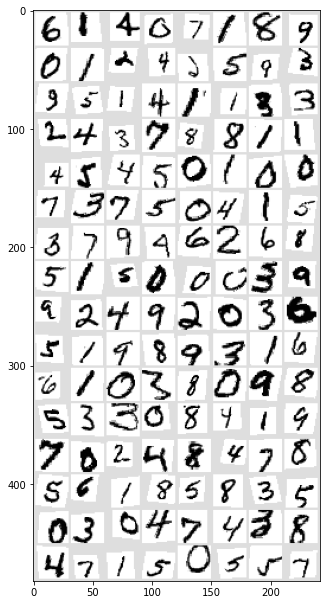

In [7]:
batch_grid = torchvision.utils.make_grid(images)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
# plt.figure(figsize=(15, 20))
plt.imshow(batch_grid[0].squeeze(),cmap='gray_r') ## the image changes for every rerun as iter object is used

In [8]:
dropout_value = 0.0
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=6, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(2, 2)
        ) # output_size = 12

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # -> 10
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False), # -> 8
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            # nn.MaxPool2d(2, 2),
        ) # output_size = 6

        # self.convblock3 = nn.Sequential(
        #     nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(8),
        #     # nn.Dropout(p=0.1),
        #     nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
            # nn.BatchNorm2d(32),
            # nn.Conv2d(in_channels=32, out_channels=24, kernel_size=(1, 1), padding=0),
            # nn.ReLU(),
            # nn.Dropout(p=0.1),
        # ) 

        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            # nn.Linear(32, 10),
        ) # output_size = 1

        self.classifier = nn.Sequential(
            # nn.Linear(16, 12),
            nn.Linear(14, 10))

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        # x = self.convblock3(x)
        x = self.gap(x)   
        x = x.view(-1, 14)
        x = self.classifier(x)

        return F.log_softmax(x,dim=1)

In [9]:
model = Net().to(device)
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
            Conv2d-4           [-1, 16, 24, 24]           1,728
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7            [-1, 6, 24, 24]              96
              ReLU-8            [-1, 6, 24, 24]               0
       BatchNorm2d-9            [-1, 6, 24, 24]              12
        MaxPool2d-10            [-1, 6, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]             648
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
           Conv2d-14             [-1, 1

In [22]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
incorr_X = []
incorr_y = []
incorr_labl = []
incorr_val = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    y_pred = model(data)
    
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)
    
    loss.backward()
    optimizer.step()
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    

    model.eval()

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            ls = output.argmax(dim=1)
            for idx, i in enumerate(ls):
                if i.item() != target[idx]:
                    incorr_X.append(torch.cat([data[idx]]))
                    incorr_y.append(target[idx].item())
                    incorr_labl.append(i.item())
                    incorr_val.append(torch.max(output[idx]).item())

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [23]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.03)
scheduler = StepLR(optimizer, step_size=9, gamma=0.1)

In [24]:
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/468 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.2011408656835556 Batch_id=467 Accuracy=81.19: 100%|██████████| 468/468 [00:26<00:00, 17.66it/s]
  0%|          | 0/468 [00:00<?, ?it/s]


Test set: Average loss: 0.0927, Accuracy: 9703/10000 (97.03%)

EPOCH: 2


Loss=0.13309641182422638 Batch_id=467 Accuracy=95.09: 100%|██████████| 468/468 [00:26<00:00, 17.43it/s]
  0%|          | 0/468 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9861/10000 (98.61%)

EPOCH: 3


Loss=0.16753338277339935 Batch_id=467 Accuracy=96.20: 100%|██████████| 468/468 [00:26<00:00, 17.64it/s]
  0%|          | 0/468 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9853/10000 (98.53%)

EPOCH: 4


Loss=0.07772763818502426 Batch_id=467 Accuracy=96.78: 100%|██████████| 468/468 [00:26<00:00, 17.56it/s]
  0%|          | 0/468 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9870/10000 (98.70%)

EPOCH: 5


Loss=0.11226140707731247 Batch_id=467 Accuracy=97.09: 100%|██████████| 468/468 [00:26<00:00, 17.56it/s]
  0%|          | 0/468 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9876/10000 (98.76%)

EPOCH: 6


Loss=0.12015903741121292 Batch_id=467 Accuracy=97.27: 100%|██████████| 468/468 [00:26<00:00, 17.52it/s]
  0%|          | 0/468 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9883/10000 (98.83%)

EPOCH: 7


Loss=0.10155422240495682 Batch_id=467 Accuracy=97.32: 100%|██████████| 468/468 [00:26<00:00, 17.59it/s]
  0%|          | 0/468 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9878/10000 (98.78%)

EPOCH: 8


Loss=0.04851950705051422 Batch_id=467 Accuracy=97.61: 100%|██████████| 468/468 [00:26<00:00, 17.43it/s]
  0%|          | 0/468 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9899/10000 (98.99%)

EPOCH: 9


Loss=0.0739055722951889 Batch_id=467 Accuracy=97.61: 100%|██████████| 468/468 [00:26<00:00, 17.75it/s]
  0%|          | 0/468 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9887/10000 (98.87%)

EPOCH: 10


Loss=0.05456429719924927 Batch_id=467 Accuracy=98.13: 100%|██████████| 468/468 [00:26<00:00, 17.68it/s]
  0%|          | 0/468 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.03974156826734543 Batch_id=467 Accuracy=98.25: 100%|██████████| 468/468 [00:26<00:00, 17.44it/s]
  0%|          | 0/468 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9914/10000 (99.14%)

EPOCH: 12


Loss=0.027166256681084633 Batch_id=467 Accuracy=98.27: 100%|██████████| 468/468 [00:26<00:00, 17.58it/s]
  0%|          | 0/468 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9919/10000 (99.19%)

EPOCH: 13


Loss=0.0536845363676548 Batch_id=467 Accuracy=98.25: 100%|██████████| 468/468 [00:26<00:00, 17.44it/s]
  0%|          | 0/468 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9920/10000 (99.20%)

EPOCH: 14


Loss=0.07120539993047714 Batch_id=467 Accuracy=98.36: 100%|██████████| 468/468 [00:26<00:00, 17.41it/s]
  0%|          | 0/468 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9923/10000 (99.23%)

EPOCH: 15


Loss=0.026310594752430916 Batch_id=467 Accuracy=98.30: 100%|██████████| 468/468 [00:26<00:00, 17.43it/s]



Test set: Average loss: 0.0196, Accuracy: 9926/10000 (99.26%)



In [61]:
def ploting(model,loader):
    img,label = loader
    with torch.no_grad():
        pred_label = model(img.to(device))
        pred= pred_label.argmax(dim=1,keepdim=True)
        
        ls = pred_label.argmax(dim=1)

        for idx, i in enumerate(ls):
            if i.item() != label[idx]:
                ground_truth = torch.max(pred_label[idx]).item()
                plt.show()
                print(f'Actual label:{label[idx]}\t Predicted label:{i.item()} \t Softmax Value{ground_truth}')
                plt.imshow(img[idx].cpu().data.numpy().squeeze())

Actual label:6	 Predicted label:5 	 Softmax Value-0.0343514047563076


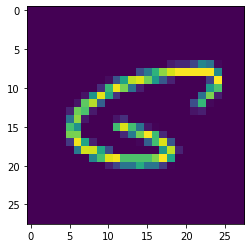

Actual label:5	 Predicted label:3 	 Softmax Value-0.2929888665676117


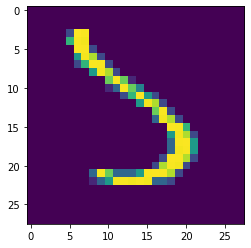

Actual label:5	 Predicted label:7 	 Softmax Value-0.05901666730642319


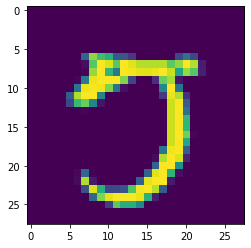

Actual label:6	 Predicted label:5 	 Softmax Value-0.0343514047563076


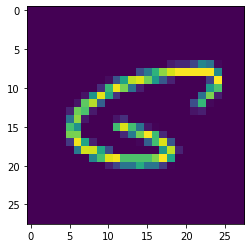

Actual label:9	 Predicted label:4 	 Softmax Value-0.16967572271823883


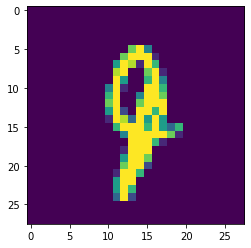

Actual label:1	 Predicted label:3 	 Softmax Value-0.7459643483161926


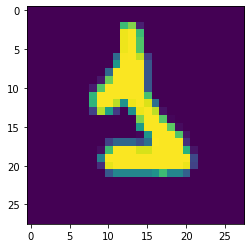

Actual label:6	 Predicted label:4 	 Softmax Value-0.003586528589949012


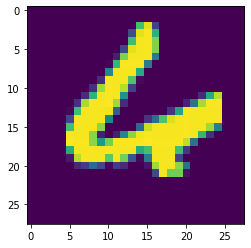

In [62]:
for i in range(10):
    batch = next(iter(test_loader))
    ploting(model,batch)